# T3: Neural IBM1 with collocations

Neural IBM 1 with additional collocations (Section 2.2 of the notebook).

We introduce a binary latent variable c  which decides between English components and French components. That is, when  c=0 we generate a French word by translating an English word, when  c=1 we generate a French word by inserting it from monolingual (French) context.

In [10]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from utils import smart_reader, bitext_reader
from vocabulary import OrderedCounter, Vocabulary 
from utils import iterate_minibatches, prepare_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [7]:
# the paths to our training and validation data, English side
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

These are the vocabularies that we use further on.

In [8]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

## T3 model

We will import the NeuralIBM1Model from T3.py and NeuralIBM1Trainer from T3trainer.py. But to show the code, we include it here:

In [ ]:
import numpy as np
import tensorflow as tf
from aer import read_naacl_alignments, AERSufficientStatistics
from utils import iterate_minibatches, prepare_data

# for TF 1.1
import tensorflow
try:
  from tensorflow.contrib.keras.initializers import glorot_uniform
except:  # for TF 1.0
  from tensorflow.contrib.layers import xavier_initializer as glorot_uniform


class NeuralIBM1Model:
  """Our Neural IBM1 model."""

  def __init__(self, batch_size=8,
               x_vocabulary=None, y_vocabulary=None,
               emb_dim=32, mlp_dim=64,
               session=None):
  
    self.batch_size = batch_size
    self.emb_dim = emb_dim

    self.mlp_dim = mlp_dim

    self.x_vocabulary = x_vocabulary
    self.y_vocabulary = y_vocabulary
    self.x_vocabulary_size = len(x_vocabulary)
    self.y_vocabulary_size = len(y_vocabulary)

    self._create_placeholders()
    self._create_weights()
    self._build_model()

    self.saver = tf.train.Saver()
    self.session = session

  def _create_placeholders(self):
    """We define placeholders to feed the data to TensorFlow."""
    # "None" means the batches may have a variable maximum length.
    self.x  = tf.placeholder(tf.int64, shape=[None, None],
                             name = "english")
    self.yp = tf.placeholder(tf.int64, shape=[None, None],
                             name = "prev_french")
    self.y  = tf.placeholder(tf.int64, shape=[None, None],
                             name = "french")

  def _create_weights(self):
    """Create weights for the model."""
    # TIM: we need to double the input embedding size if the mode is concat.
    emb_dim = self.emb_dim

    with tf.variable_scope("MLP") as scope:
      # first layer for t
      self.mlp_Wt_ = tf.get_variable(
        name="Wt_", initializer=glorot_uniform(),
        shape=[emb_dim, self.mlp_dim])

      self.mlp_bt_ = tf.get_variable(
        name="bt_", initializer=tf.zeros_initializer(),
        shape=[self.mlp_dim])

      # first layer for i and s
      self.mlp_Wis_ = tf.get_variable(
        name="Wis_", initializer=glorot_uniform(),
        shape=[emb_dim, self.mlp_dim])

      self.mlp_bis_ = tf.get_variable(
        name="bis_", initializer=tf.zeros_initializer(),
        shape=[self.mlp_dim])

      # layer for translation P(F|E)
      self.mlp_W_t = tf.get_variable(
        name="W_t", initializer=glorot_uniform(),
        shape=[self.mlp_dim, self.y_vocabulary_size])

      self.mlp_b_t = tf.get_variable(
        name="b_t", initializer=tf.zeros_initializer(),
        shape=[self.y_vocabulary_size])

      # layer for insertion P(F|Fprev)
      self.mlp_W_i = tf.get_variable(
        name="W_i", initializer=glorot_uniform(),
        shape=[self.mlp_dim, self.y_vocabulary_size])

      self.mlp_b_i = tf.get_variable(
        name="b_i", initializer=tf.zeros_initializer(),
        shape=[self.y_vocabulary_size])

      # layer for collocation P(C|Fprev)
      self.mlp_W_s = tf.get_variable(
        name="W_s", initializer=glorot_uniform(),
        shape=[self.mlp_dim, 1])

      self.mlp_b_s = tf.get_variable(
        name="b_s", initializer=tf.zeros_initializer(),
        shape=[1])

  def save(self, session, path="model.ckpt"):
    """Saves the model."""
    return self.saver.save(session, path)

  def _build_model(self):
    """Builds the computational graph for our model."""

    # 1. Let's create a (source) word embeddings matrix.
    # These are trainable parameters, so we use tf.get_variable.
    # Shape: [Vx, emb_dim] where Vx is the source vocabulary size
    x_embeddings = tf.get_variable(
      name="x_embeddings", initializer=tf.random_uniform_initializer(),
      shape=[self.x_vocabulary_size, self.emb_dim])
    y_embeddings = tf.get_variable(
      name="y_embeddings", initializer=tf.random_uniform_initializer(),
      shape=[self.y_vocabulary_size, self.emb_dim])

    emb_dim = self.emb_dim

    # Now we start defining our graph.

    # 2. Now we define the generative model P(Y | X=x)
    
    # first we need to know some sizes from the current input data
    batch_size = tf.shape(self.x)[0]
    longest_x = tf.shape(self.x)[1]  # longest M
    longest_y = tf.shape(self.y)[1]  # longest N

    # Input yp
    twos = 2*tf.ones([tf.shape(self.y)[0], 1], tf.int64) # prepend all the sentences with '2', the code for <S>
    yp = tf.concat([twos, self.y[:,:-1]], axis=1, name='concat-twos')
    self.y_p = yp
    yp_embedded = tf.nn.embedding_lookup(y_embeddings, yp) # Shape: [B, N, emb_dim]
    self.yp_embedded = yp_embedded

    # Input x
    x_embedded = tf.nn.embedding_lookup(x_embeddings, self.x) # Shape: [B, M, emb_dim]
    

    # It's also useful to have masks that indicate what
    # values of our batch we should ignore.
    # Masks have the same shape as our inputs, and contain
    # 1.0 where there is a value, and 0.0 where there is padding.
    x_mask  = tf.cast(tf.sign(self.x), tf.float32)    # Shape: [B, M]
    y_mask  = tf.cast(tf.sign(self.y), tf.float32)    # Shape: [B, N]
    x_len   = tf.reduce_sum(tf.sign(self.x), axis=1)  # Shape: [B]
    y_len   = tf.reduce_sum(tf.sign(self.y), axis=1)  # Shape: [B]

    # 2.a Build an alignment model P(A | X, M, N)

    # This just gives you 1/length_x (already including NULL) per sample.
    # i.e. the lengths are the same for each word y_1 .. y_N.
    lengths  = tf.expand_dims(x_len, -1)  # Shape: [B, 1]
    pa_x     = tf.div(x_mask, tf.cast(lengths, tf.float32))   # Shape: [B, M]

    # We now have a matrix with 1/M values.
    # For a batch of 2 setencnes, with lengths 2 and 3:
    #
    #  pa_x = [[1/2 1/2   0]
    #          [1/3 1/3 1/3]]
    #
    # But later we will need it N times. So we repeat (=tile) this
    # matrix N times, and for that we create a new dimension
    # in between the current ones (dimension 1).
    pa_x  = tf.expand_dims(pa_x, 1)  # Shape: [B, 1, M]

    #  pa_x = [[[1/2 1/2   0]]
    #          [[1/3 1/3 1/3]]]
    # Note the extra brackets.

    # Now we perform the tiling:
    pa_x  = tf.tile(pa_x, [1, longest_y, 1])  # [B, N, M]

    # pa_x = tf.tile(y_embedded, [1, 1, longest_y])

    # Result:
    #  pa_x = [[[1/2 1/2   0]
    #           [1/2 1/2   0]]
    #           [[1/3 1/3 1/3]
    #           [1/3 1/3 1/3]]]

    # The MLP

    # This is for P(F|E), translation t
    mlp_input = tf.reshape(x_embedded, [batch_size * longest_x, emb_dim])
    h_t = tf.matmul(mlp_input, self.mlp_Wt_, name='x1') + self.mlp_bt_ # Shape [B*M, emb_dim]
    h_t  = tf.tanh(h_t)
    h_t = tf.matmul(h_t, self.mlp_W_t, name='x2') + self.mlp_b_t # Shape [B*M, emb_dim]
    # Now we perform a softmax which operates on a per-row basis.
    py_xa = tf.nn.softmax(h_t)
    # This is P(F|E)
    py_xa = tf.reshape(py_xa, [batch_size, longest_x, self.y_vocabulary_size]) # Shape [B, M, Vy]

    # This is for P(F|Fprev) and P(C|Fprev), insertion i and collocation c
    # Note: Shared first layer!
    mlp_input = tf.reshape(yp_embedded, [batch_size * longest_y, emb_dim])
    h_is = tf.matmul(mlp_input, self.mlp_Wis_, name='y1') + self.mlp_bis_ # Shape [B*N, emb_dim]
    h_is  = tf.tanh(h_is)
    # This is P(F|Fprev) insertion i
    h_i = tf.matmul(h_is, self.mlp_W_i, name='y2') + self.mlp_b_i # Shape [B*N, emb_dim]
    py_y  = tf.nn.softmax(h_i) # Shape: [B*N, Vy]
    py_y = tf.reshape(py_y, [batch_size, longest_y, self.y_vocabulary_size]) # Shape [B, N, Vy]
    # This is s(Fprev) for P(C|Fprev) = Bern(s(Fprev))
    h_s = tf.matmul(h_is, self.mlp_W_s, name='3')
    h_s = h_s + self.mlp_b_s
    s = tf.sigmoid(h_s)
    s = tf.squeeze(s) # get rid of trainling 1-dimension
    s = tf.reshape(s, [batch_size, longest_y])

    # alpha = tf.matmul(yp, self.alpha_W) + self.alpha_b  # [B * M, z_dim]
    # beta = tf.matmul(yp, self.beta_W) + self.beta_b  # [B * M, z_dim]
    # # IMPORTANT: used for sampling gate values s:
    # a = tf.matmul(yp, self.a_W) + self.a_b  # [B * M, z_dim]
    # b = tf.matmul(yp, self.b_W) + self.b_b  # [B * M, z_dim]


    # 2.c Marginalise alignments: \sum_a P(a|x) P(Y|x,a)

    # Here comes a rather fancy matrix multiplication.
    # Note that tf.matmul is defined to do a matrix multiplication
    # [N, M] @ [M, Vy] for each item in the first dimension B.
    # So in the final result we have B matrices [N, Vy], i.e. [B, N, Vy].
    #
    # We matrix-multiply:
    #   pa_x       Shape: [B, N, *M*]
    #       pa_x       Shape: [B, N, *N*M*]
    # and
    #   py_xa      Shape: [B, *M*, Vy]
    #       py_xa      Shape: [B, *N*M*, Vy]
    # to get
    #   py_x  Shape: [B, N, Vy]
    #
    # Note: P(y|x) = prod_j p(y_j|x) = prod_j sum_aj p(aj|m)p(y_j|x_aj)
    py_x = tf.matmul(pa_x, py_xa, name='3')  # Shape: [B, N, Vy]

    # Read the equation in Theory 2.2 carefully. Then you will see that this is correct.
    s_tiled = tf.expand_dims(s, 2) # Shape: [B, N, 1]
    s_tiled = tf.tile(s_tiled, [1, 1, self.y_vocabulary_size]) # Shape: [B, N, Vy]
    # Here we marginalise over S
    py_x = tf.multiply(s_tiled, py_x, name='s1') + tf.multiply(1-s_tiled, py_y, name='s2')

    # This calculates the accuracy, i.e. how many predictions we got right.
    predictions = tf.argmax(py_x, axis=2)
    acc = tf.equal(predictions, self.y)
    acc = tf.cast(acc, tf.float32) * y_mask
    acc_correct = tf.reduce_sum(acc)
    acc_total = tf.reduce_sum(y_mask)
    acc = acc_correct / acc_total

    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=tf.reshape(self.y, [-1]),
      logits=tf.log(tf.reshape(py_x,[batch_size * longest_y, self.y_vocabulary_size], name='lastfucker')),
      name="logits"
    )
    cross_entropy = tf.reshape(cross_entropy, [batch_size, longest_y])
    cross_entropy = tf.reduce_sum(cross_entropy * y_mask, axis=1)
    cross_entropy = tf.reduce_mean(cross_entropy, axis=0)


    self.pa_x = pa_x
    self.py_x = py_x
    self.py_y = py_y
    self.py_xa = py_xa
    self.s = s
    self.loss = cross_entropy
    self.predictions = predictions
    self.accuracy = acc
    self.accuracy_correct = tf.cast(acc_correct, tf.int64)
    self.accuracy_total = tf.cast(acc_total, tf.int64)


  def evaluate(self, data, ref_alignments, batch_size=4):
    """Evaluate the model on a data set."""

    ref_align = read_naacl_alignments(ref_alignments)

    ref_iterator = iter(ref_align)
    metric = AERSufficientStatistics()
    accuracy_correct = 0
    accuracy_total = 0

    for batch_id, batch in enumerate(iterate_minibatches(data, batch_size=batch_size)):
      x, y = prepare_data(batch, self.x_vocabulary, self.y_vocabulary)
      y_len = np.sum(np.sign(y), axis=1, dtype="int64")

      align, prob, acc_correct, acc_total = self.get_viterbi(x, y)
      accuracy_correct += acc_correct
      accuracy_total += acc_total

      for alignment, N, (sure, probable) in zip(align, y_len, ref_iterator):
        # the evaluation ignores NULL links, so we discard them
        # j is 1-based in the naacl format
        pred = set((aj, j) for j, aj in enumerate(alignment[:N], 1) if aj > 0)
        metric.update(sure=sure, probable=probable, predicted=pred)

    accuracy = accuracy_correct / float(accuracy_total)
    return metric.aer(), accuracy


  def get_viterbi(self, x, y):
    """Returns the Viterbi alignment for (x, y)"""

    feed_dict = {
      self.x: x, # English
      self.y: y, # French
    }

    # run model on this input
    py_xa, py_y, s, acc_correct, acc_total = self.session.run(
      [self.py_xa,
       self.py_y,
       self.s,
       self.accuracy_correct, 
       self.accuracy_total],
       feed_dict=feed_dict)

    # things to return
    batch_size, longest_y = y.shape
    _, longest_x = x.shape
    alignments = np.zeros((batch_size, longest_y), dtype="int64")
    probabilities = np.zeros((batch_size, longest_y), dtype="float32")

    for b, sentence in enumerate(y):
      for j, french_word in enumerate(sentence):
        if french_word == 0:  # Padding
          break
        fprev = j
        sj = s[b,j]
        # if b in range(20): print(sj)
        c = int(np.random.uniform() < sj) # sample c ~ Bernouilli(sj)
        if c == 0: # then we align
            probs = py_xa[b, : , y[b,j]] # y[b,j] means only the word f_j in the sentence b
            a_j = probs.argmax()
            p_j = probs[a_j]
        if c == 1: # then we `insert` (i.e. NULL align - see NLP2 blog post)
            # if b in range(20): print('Null aligned')
            a_j = 0 # NULL align
            p_j = 1

        alignments[b, j] = a_j
        probabilities[b, j] = p_j


    return alignments, probabilities, acc_correct, acc_total

In [11]:
from T3 import NeuralIBM1Model
from T3trainer import NeuralIBM1Trainer

In [51]:
tf.reset_default_graph()



with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=2000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 67.262512 accuracy 0.09 lr 0.001000
Epoch 1 loss 63.036542 accuracy 0.21 val_aer 0.88 val_acc 0.19
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss 58.231434 accuracy 0.17 lr 0.001000
Epoch 2 loss 54.453674 accuracy 0.23 val_aer 0.87 val_acc 0.20
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss 50.490299 accuracy 0.24 lr 0.001000
Epoch 3 loss 49.892649 accuracy 0.26 val_aer 0.84 val_acc 0.20
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss 46.058716 accuracy 0.26 lr 0.001000
Epoch 4 loss 47.309650 accuracy 0.28 val_aer 0.82 val_acc 0.21
Computing training-set likelihood
Computing dev-set likeliho

### Plots

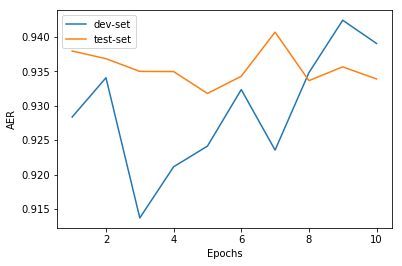

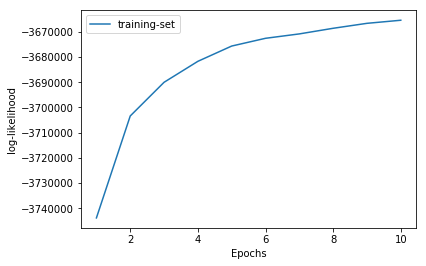

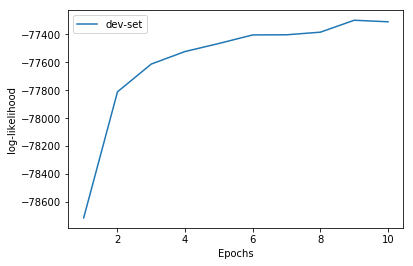

In [50]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

## Neural IBM1 withouth French context

For comparison purposes we include the results of the originial neural IBM1.

In [33]:
from neuralibm1 import NeuralIBM1Model
from neuralibm1trainer import NeuralIBM1Trainer

In [34]:
tf.reset_default_graph()


with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=10000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())


    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 66.535721 accuracy 0.22 lr 0.001000
Iter   200 loss 58.521881 accuracy 0.22 lr 0.001000
Iter   300 loss 64.783844 accuracy 0.20 lr 0.001000
Iter   400 loss 43.832909 accuracy 0.24 lr 0.001000
Iter   500 loss 55.865246 accuracy 0.20 lr 0.001000
Iter   600 loss 69.351669 accuracy 0.21 lr 0.001000
Iter   700 loss 54.295448 accuracy 0.24 lr 0.001000
Epoch 1 loss 64.711381 accuracy 0.19 val_aer 0.65 val_acc 0.19
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss 71.635216 accuracy 0.17 lr 0.001000
Iter   200 loss 75.882431 accuracy 0.16 lr 0.001000
Iter   300 loss 60.810463 accuracy 0.15 lr 0.001000
Iter   400 loss 70.482773 accuracy 0.22 lr 0.001000
Iter   500 loss 61.605980 accuracy 0.12 lr 0.001000
Iter   600 loss 56.401680 accuracy 0.22 lr 0.001000
Iter   700 loss 68.

### Plots

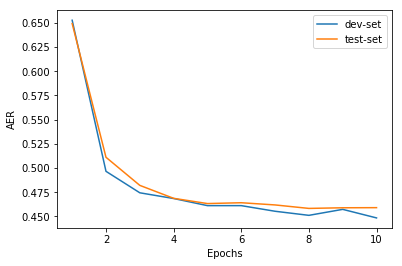

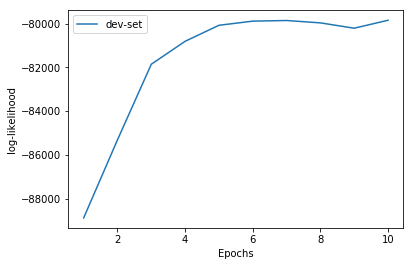

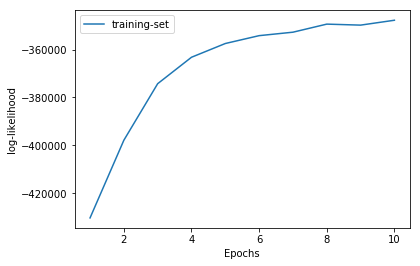

In [35]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()